# ENEL 645 Assignment 2
Group 11 Team Members: Steven Au, Laurel Flanagan, Rhys Wickens, Austen Zhang

## Experiment Setup

This experiment aims to train a MultiModal model for garbage classification, to help Calgarians properly dispose of waste into green, blue, black or other bins. This dataset was provided by Dr. Robert Souza as part of the ENEL645 course. The data was pre-split into train, validation, and test sets, composing of 11,629 samples in the train set, 188 samples in the validation set, and 2346 samples in the test set.

## Summary

A custom MultiModal neural network was built. For images, EfficientNetV2s was used for feature extraction. For text data, DistilBERT uncased was used for feature extraction. After feature extraction, the outputs from each Neural Network are concatenated into one feature vector which contains both text and image information. This is then passed through a classification layer to make predictions. 

To train our model, we used a training loop which saves the best model and waits 10 epochs until stopping training. We found that our model triggered early stopping at epoch 13, taking 5640 seconds.

## Experimental Process

As part of the experimentation process, we set up Weights and Biases to monitor model performance. To select the model for image feature extraction, we trained MobileNetV2, and EfficientNetV2s with a single classification layer. We found that EfficientNetV2s, given the same amount of epochs, batch size, and learning rate, trained faster than MobileNetV2. EfficientNetV2s also out performed MobileNetV2s when comparing test accuracies, with MobileNetV2 scoring 66.4% and EfficientNetV2s scoring slightly higher at 68.4%. 

To select the model for text feature extraction, we trained ALBERT and DistilBERT Uncased. Given the same amount of epochs, batch size, learning rate and drop out, ALBERT scored a test accuracy of 83% and DistilBERT scored higher at 88.9%.

After selecting models, a hyperparameter search was performed to find a learning rate for each model, and a unified batch_size suitable for both models. We selected a batch size of 128 for the MultiModal model, based on the observation that the validation accuracy appeared to have the highest chance of converging over a smaller number of epochs.

Each model was used in parallel to build the Multimodal model, which processes the input text and dataset. The Multimodal model concatenates the features extracted by EfficientNetV2s and DistilBERT. The results from the feature extraction are joined into a vector which contains the extracted features, and is passed through a prediction layer with dropout to improve model generalization.

For the same hyperparameters, we found that EfficientNetV2s had a test accuracy of 75.9%. For text feature extraction, we found that DistilBERT had a test accuracy of 85.0% for the same set of hyperparemeters in our Multimodal model. Fusing the two models resulted in a test accuracy of 88.1%, which outperforms the highest test accuracy of the individual feature extraction models.

## Garbage Classification Transfer Learning
Pre-trained Model: Efficient Net V2 S (https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.efficientnet_v2_s)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import os
import re
import numpy as np
from transformers import DistilBertModel, DistilBertTokenizer
import wandb

# ========================================= GLOBAL CONFIGURATION ================================================
# Data Directories
DATA_DIR = "C:/Users/Auste/Documents/ENEL645_GarbageData/"
TRAIN_DIR = os.path.join(DATA_DIR, "CVPR_2024_dataset_Train")
VAL_DIR = os.path.join(DATA_DIR, "CVPR_2024_dataset_Val")
TEST_DIR = os.path.join(DATA_DIR, "CVPR_2024_dataset_Test")

# Model and Training Configuration
MODEL_NAME = "efficientnetv2s_distilbert_multimodal"
IMAGE_SIZE = (384, 384) # Image size
NUM_WORKERS = 4 # Parallel data loading processes
NUM_CLASSES = 4 # For prediction layer
BATCH_SIZE = 128 # Number of samples
MAX_LEN = 24 # For DistilBERT
EPOCHS = 50 # Max epochs
LEARNING_RATE_EFFICIENTNET = 0.001 # EfficientNetV2s
LEARNING_RATE_DISTILBERT = 0.0001 # DistilBERT Uncased
DROPOUT = 0.3 # For DistilBERT 
CONVERGENCE_THRESHOLD = 0.001  # Minimum improvement in validation loss
PATIENCE = 10 # Number of epochs to wait for improvement

# Wandb Configuration
WANDB_CONFIG = {
    "entity": "shcau-university-of-calgary-in-alberta",
    "project": "transfer_learning_garbage",
    "name": "Multimodal_Model_Train_Model",
    "tags": ["distilBERT", "efficientnet", "CVPR_2024_dataset"],
    "notes": "Assignment 2 Train Model",
    "config": {"epochs": EPOCHS, "batch_size": BATCH_SIZE, "dataset": "CVPR_2024_dataset"},
    "job_type": "train",
    "resume": "allow",
}

# Normalization Stats
NORMALIZATION_STATS = {
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225],
}

# ========================================= HELPER FUNCTIONS ================================================
# Initialize wandb
def initialize_wandb():
    if wandb.run is None:
        wandb.init(**WANDB_CONFIG)

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)

# ========================================= DATASET CLASSES ================================================
class CustomTextDataset(Dataset): # Initializes text dataset
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts # stores a list of text samples
        self.labels = labels # stores list of corresponding labels
        self.tokenizer = tokenizer # DistilBERT tokenizer
        self.max_len = max_len # Maximum length for tokenized sequences (MAX_LEN = 24)

    def __len__(self): # Returns number of samples
        return len(self.texts)

    def __getitem__(self, idx): # Retrieves sample by index `idx`
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus( # Tokenize text
            text,
            add_special_tokens=True, # Add special tokens to separate text input
            max_length=self.max_len, # Truncates or pads the sequence to max_len
            return_token_type_ids=False, # Does not return token type IDs
            padding='max_length', # Pad text to max length
            truncation=True, # Truncates text sample if exceeds max_len = 24
            return_attention_mask=True, # Return attention mask to pay attention to token and not padding tokens
            return_tensors='pt' # Return PyTorch tensor
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(), # Flatten input sample tensor
            'attention_mask': encoding['attention_mask'].flatten(), # Flatten attention mask
            'label': torch.tensor(label, dtype=torch.long) # Convert label to PyTorch tensor
        }

# MultimodalDataset class to handle multimodal data 
class MultimodalDataset(Dataset): 
    def __init__(self, image_dataset, text_dataset):
        self.image_dataset = image_dataset # Stores image dataset
        self.text_dataset = text_dataset # Stores text dataset

    def __len__(self):
        return min(len(self.image_dataset), len(self.text_dataset))

    def __getitem__(self, idx): # returns a sample containing both text and image data
        image, label = self.image_dataset[idx]
        text_data = self.text_dataset[idx]
        return {
            "image": image, 
            "input_ids": text_data["input_ids"],
            "attention_mask": text_data["attention_mask"],
            "label": label
        }

# ========================================= MODEL DEFINITION ================================================
class MultimodalClassifier(nn.Module): # Build custom Neural Network using nn.Module
    def __init__(self, num_classes):
        super(MultimodalClassifier, self).__init__() # Call constructor parent class nn.Module

        # EfficientNetV2s which extracts features from image data
        self.image_model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

        # Freeze EfficientNetV2s feature layers
        for param in self.image_model.features.parameters():
            param.requires_grad = False

        num_ftrs = self.image_model.classifier[1].in_features

        # Remove to make use of custom prediction layer
        self.image_model.classifier = nn.Identity()

        # Project features to 256 dimensions
        self.image_fc = nn.Linear(num_ftrs, 256)

        # DistilBERT which extracts features from text data
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 256)

        # Normalization layers
        self.text_norms = nn.LayerNorm(256)
        self.image_norm = nn.LayerNorm(256)

        # Feature fusion Layer (Concatenation)
        self.fusion_fc = nn.Linear(512, self.text_model.config.hidden_size)

        # Classification Layer
        self.classifier = nn.Linear(self.text_model.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3) # Apply dropout to learn only the more features (keep higher signals)
        
    def forward(self, input_ids, attention_mask, image_inputs):
        # Extract text features
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_norms(self.text_fc(text_output.last_hidden_state[:, 0, :]))  # Extract sequence of token embeddings 

        # Extract image features
        image_features = self.image_norm(self.image_fc(self.image_model(image_inputs)))

        # Concatenate text and image features
        combined_features = torch.cat((text_features, image_features), dim=1)

        # Pass through fusion and classification layers
        combined_features = self.fusion_fc(combined_features)
        output = self.classifier(self.dropout(combined_features))

        return output


# ========================================= EVALUATION FUNCTION ================================================
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            # Send data to GPU
            images, input_ids, attention_mask, labels = batch["image"].to(device), batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
            outputs = model(input_ids, attention_mask, images) # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item() # Compute accuracy
            total += labels.size(0)

    accuracy = correct / total # Calculate average loss and accuracy
    return total_loss / len(dataloader), accuracy


# ========================================= TRAINING LOOP ================================================
def train_model(model, dataloaders, criterion, optimizer, device):
    initialize_wandb() # Initialize W&B using configuration

    wandb.watch(model, log="all") # Log gradients and parameters
    best_val_loss = float("inf") # Track best validation loss
    epochs_without_improvement = 0 # Track epochs without improvement until equals patience

    # Training Loop
    for epoch in range(EPOCHS):
        print(f"\nStarting Epoch {epoch + 1}/{EPOCHS}")
        model.train() # Set model to training mode
        total_train_loss = 0

        # Training phase
        for batch in dataloaders["train_loader"]:
            # Move data to device
            images, input_ids, attention_mask, labels = batch["image"].to(device), batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
            optimizer.zero_grad() # Zero gradients to prevent Gradient Accumulation across batches
            outputs = model(input_ids, attention_mask, images) # Send inputs to network and receive outputs
            loss = criterion(outputs, labels) # Calculate loss function for this batch
            loss.backward() # Back propogate to compute the gradient for each parameter and update model weights
            optimizer.step() # Take a step in the direction and update weight coefficients to minimize loss function
            total_train_loss += loss.item() # Track loss

        # Validation step to see how well model performs this epoch
        val_loss, val_acc = evaluate_model(model, dataloaders["val_loader"], device)
        
        # Log metrics of this epoch to wandb
        wandb.log({"epoch": epoch+1, "train_loss": total_train_loss, "val_loss": val_loss, "val_accuracy": val_acc})
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {total_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check for improvement in validation loss
        if val_loss < best_val_loss - CONVERGENCE_THRESHOLD:  # If loss improves, then we save the model
            best_val_loss = val_loss
            epochs_without_improvement = 0 # Reset epochs without improvement counter for patience
            torch.save(model.state_dict(), "best_multimodal_model.pth") # Save model
        else:
            epochs_without_improvement += 1 # Increment until patience reached

        # Early stopping if no improvement for epochs
        if epochs_without_improvement >= PATIENCE:
            print(f"Early stopping at epoch {epoch + 1} as validation loss did not improve for {PATIENCE} epochs.")
            break

## Data Setup

In [13]:
# Define transformations
transform = {
    "train": transforms.Compose([
        models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(), # pre-trained EfficientNetV2s image normalization
        transforms.RandomHorizontalFlip(), # Applies random horizontal flip
    ]),
    "val": models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(), # Normalize the validation set (no transformations)
    "test": models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(), # Normalize the test set (no transformations)
}

# Load dataset and apply transformations
image_datasets = {
    "train": datasets.ImageFolder(TRAIN_DIR, transform=transform["train"]), # 
    "val": datasets.ImageFolder(VAL_DIR, transform=transform["val"]),
    "test": datasets.ImageFolder(TEST_DIR, transform=transform["test"]),
}

# Read text data and corresponding labels
text_train, labels_train = read_text_files_with_labels(TRAIN_DIR)
text_val, labels_val = read_text_files_with_labels(VAL_DIR)
text_test, labels_test = read_text_files_with_labels(TEST_DIR)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Loads pre-trained DistilBERT tokenizer

# Create PyTorch dataloaders to provide batches of image and text data, used for training and evaluation
dataloaders = {
    "train_loader" : DataLoader(MultimodalDataset(image_datasets["train"], CustomTextDataset(text_train, labels_train, tokenizer, MAX_LEN)), 
                            batch_size=BATCH_SIZE, shuffle=True),
    "val_loader" : DataLoader(MultimodalDataset(image_datasets["val"], CustomTextDataset(text_val, labels_val, tokenizer, MAX_LEN)), 
                        batch_size=BATCH_SIZE, shuffle=False),
    "test_loader" : DataLoader(MultimodalDataset(image_datasets["test"], CustomTextDataset(text_test, labels_test, tokenizer, MAX_LEN)), 
                        batch_size=BATCH_SIZE, shuffle=False)}

# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Uses GPU Cuda cores
model = MultimodalClassifier(num_classes=NUM_CLASSES).to(device)  # Initializes model and sends to GPU
optimizer = optim.Adam([
    {'params': model.text_model.parameters(), 'lr': LEARNING_RATE_DISTILBERT},  
    {'params': model.image_fc.parameters(), 'lr': LEARNING_RATE_EFFICIENTNET},  
    {'params': model.classifier.parameters(), 'lr': LEARNING_RATE_EFFICIENTNET}
])
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train model using model on device, PyTorch dataloaders, Adam optimizer, and GPU
train_model(model, dataloaders, criterion, optimizer, device)  

wandb: Currently logged in as: shcau (shcau-university-of-calgary-in-alberta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Starting Epoch 1/50
Epoch 1/50, Train Loss: 37.0911, Val Loss: 0.2359, Val Acc: 0.9261

Starting Epoch 2/50
Epoch 2/50, Train Loss: 15.9234, Val Loss: 0.2263, Val Acc: 0.9178

Starting Epoch 3/50
Epoch 3/50, Train Loss: 11.3538, Val Loss: 0.2225, Val Acc: 0.9217

Starting Epoch 4/50
Epoch 4/50, Train Loss: 8.3538, Val Loss: 0.2617, Val Acc: 0.9256

Starting Epoch 5/50
Epoch 5/50, Train Loss: 7.4434, Val Loss: 0.2631, Val Acc: 0.9322

Starting Epoch 6/50
Epoch 6/50, Train Loss: 5.7203, Val Loss: 0.2844, Val Acc: 0.9161

Starting Epoch 7/50
Epoch 7/50, Train Loss: 5.8741, Val Loss: 0.2972, Val Acc: 0.9300

Starting Epoch 8/50
Epoch 8/50, Train Loss: 4.2696, Val Loss: 0.3014, Val Acc: 0.9189

Starting Epoch 9/50
Epoch 9/50, Train Loss: 4.6774, Val Loss: 0.2989, Val Acc: 0.9272

Starting Epoch 10/50
Epoch 10/50, Train Loss: 4.4777, Val Loss: 0.2999, Val Acc: 0.9261

Starting Epoch 11/50
Epoch 11/50, Train Loss: 3.3456, Val Loss: 0.3286, Val Acc: 0.9239

Starting Epoch 12/50
Epoch 12/50, T

## Evaluate Model

C:\Users\Auste\AppData\Local\Temp\ipykernel_82356\1685707627.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_multimodal_model.pth


Test Loss: 0.3439, Test Accuracy: 0.8808

Classification Report:
               precision    recall  f1-score   support

       Black       0.80      0.79      0.79       695
        Blue       0.88      0.90      0.89      1086
       Green       0.95      0.96      0.95       799
         TTR       0.89      0.86      0.88       852

    accuracy                           0.88      3432
   macro avg       0.88      0.88      0.88      3432
weighted avg       0.88      0.88      0.88      3432



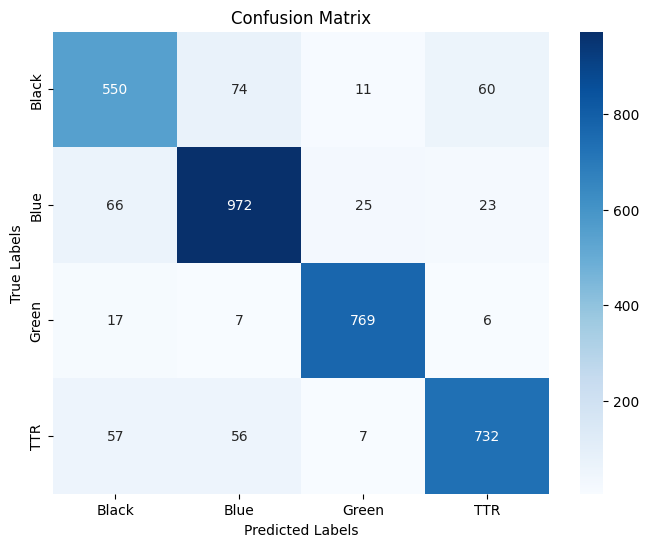

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ========================================= TESTING FUNCTION WITH METRICS ================================================

def test_model_with_metrics(model, dataloader, device, class_labels):
    """Evaluates the model and computes confusion matrix, precision, recall, and F1-score."""
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            # Move data to GPU
            images, input_ids, attention_mask, labels = (
                batch["image"].to(device),
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["label"].to(device),
            )

            # Forward pass
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions
            preds = outputs.argmax(dim=1)  # Get the class with highest probability
            all_preds.extend(preds.cpu().numpy())  # Move to CPU and store predictions
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Compute Accuracy
    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names = class_labels)

    print(f"\nTest Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", class_report)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Log metrics to wandb
    wandb.log({"Test Accuracy": accuracy})
    wandb.log({"Confusion Matrix": wandb.Image(plt)})

    return accuracy, class_report

# ========================================= RUN TESTING & METRICS ================================================

# Load the best saved model before testing
model.load_state_dict(torch.load("best_multimodal_model.pth"))

# Get labels for classes
class_labels = image_datasets["test"].classes

# Evaluate on the test dataset
test_accuracy, test_report = test_model_with_metrics(model, dataloaders["test_loader"], device, class_labels)

wandb.finish()
